In [1]:
#hide
from utils import *

# Other Computer Vision Problems

## Multi-Label Classification

### The Data

In [2]:
from fastai2.vision.all import *
path = untar_data(URLs.PASCAL_2007)

In [3]:
df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


In [4]:
df[df["is_valid"]].shape[0], df.shape[0]

(2510, 5011)

### Constructing a DataBlock

In [5]:
dblock = DataBlock()

In [6]:
dsets = dblock.datasets(df)

In [7]:
len(dsets.train),len(dsets.valid)

(4009, 1002)

In [8]:
x,y = dsets.train[0]
x,y

(fname       008663.jpg
 labels      car person
 is_valid         False
 Name: 4346, dtype: object,
 fname       008663.jpg
 labels      car person
 is_valid         False
 Name: 4346, dtype: object)

In [9]:
x['fname']

'008663.jpg'

In [10]:
dblock = DataBlock(get_x = lambda r: r['fname'], get_y = lambda r: r['labels'])
dsets = dblock.datasets(df)
dsets.train[0]

('005620.jpg', 'aeroplane')

In [11]:
def get_x(r): return r['fname']
def get_y(r): return r['labels']
dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

('002549.jpg', 'tvmonitor')

In [12]:
def get_x(r): return path/'train'/r['fname']
def get_y(r): return r['labels'].split(' ')
dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(Path('/storage/data/pascal_2007/train/002844.jpg'), ['train'])

label:  ['cat']


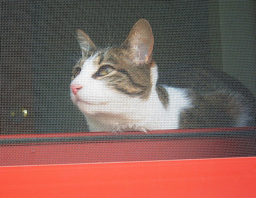

In [13]:
n = 15
img = Image.open(dsets.train[n][0])
print("label: ", dsets.train[n][1])
img.to_thumb(256, 256)


In [14]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x375,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [15]:
idxs = torch.where(dsets.train[19][1]==1.)[0]
dsets.train.vocab[idxs]

(#2) ['bottle','person']

In [16]:
def splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].tolist()
    return train,valid

dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x, 
                   get_y=get_y)

dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [17]:
len(dsets.valid), len(dsets.train)

(2510, 2501)

In [18]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x, 
                   get_y=get_y,
                   item_tfms = RandomResizedCrop(128, min_scale=0.35))
dls = dblock.dataloaders(df)

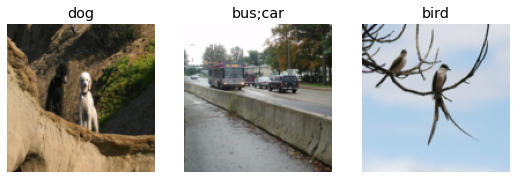

In [19]:
dls.show_batch(nrows=1, ncols=3)

### Binary Cross-Entropy

In [20]:
learn = cnn_learner(dls, resnet18)

In [21]:
x,y = dls.train.one_batch()
activs = learn.model(x)
activs.shape

torch.Size([64, 20])

In [22]:
activs[0]

tensor([-3.0027, -0.4363, -0.5106,  2.0305, -1.6218,  0.2815, -0.6537,  2.7582, -1.0932,  3.6859, -3.1152, -3.0071, -0.8291, -2.1153,  2.5191, -0.0915, -1.3371, -1.5343,  0.8113, -5.0259],
       device='cuda:0', grad_fn=<SelectBackward>)

In [23]:
def binary_cross_entropy(inputs, targets):
    inputs = inputs.sigmoid()
    return -torch.where(targets==1, inputs, 1-inputs).log().mean()

In [24]:
loss_func = nn.BCEWithLogitsLoss()
loss = loss_func(activs, y)
loss

tensor(1.0624, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

In [25]:
def say_hello(name, say_what="Hello"): return f"{say_what} {name}."
say_hello('Jeremy'),say_hello('Jeremy', 'Ahoy!')

('Hello Jeremy.', 'Ahoy! Jeremy.')

In [26]:
f = partial(say_hello, say_what="Bonjour")
f("Jeremy"),f("Sylvain")

('Bonjour Jeremy.', 'Bonjour Sylvain.')

In [27]:
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.2))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.938092,0.698614,0.236912,00:23
1,0.821270,0.556116,0.295378,00:22
2,0.603103,0.199637,0.829482,00:22
3,0.359695,0.124229,0.938984,00:22


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.134445,0.114110,0.943048,00:26
1,0.117568,0.108565,0.949601,00:26
2,0.097927,0.103895,0.953068,00:26


In [28]:
learn.metrics = partial(accuracy_multi, thresh=0.1)
learn.validate()

(#2) [0.10389477014541626,0.9330277442932129]

In [29]:
learn.metrics = partial(accuracy_multi, thresh=0.99)
learn.validate()

(#2) [0.10389477014541626,0.9440439343452454]

In [30]:
preds,targs = learn.get_preds()

In [31]:
accuracy_multi(preds, targs, thresh=0.9, sigmoid=False)

TensorMultiCategory(0.9574)

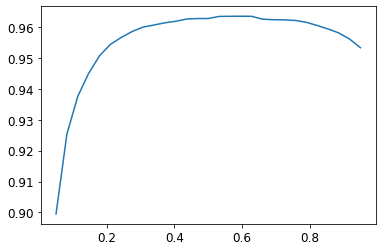

In [32]:
xs = torch.linspace(0.05,0.95,29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs,accs);

## Regression

### Assemble the Data

In [33]:
path = untar_data(URLs.BIWI_HEAD_POSE)

In [34]:
#hide
Path.BASE_PATH = path

In [35]:
path.ls().sorted()

(#50) [Path('01'),Path('01.obj'),Path('02'),Path('02.obj'),Path('03'),Path('03.obj'),Path('04'),Path('04.obj'),Path('05'),Path('05.obj')...]

In [36]:
(path/'01').ls().sorted()

(#1000) [Path('01/depth.cal'),Path('01/frame_00003_pose.txt'),Path('01/frame_00003_rgb.jpg'),Path('01/frame_00004_pose.txt'),Path('01/frame_00004_rgb.jpg'),Path('01/frame_00005_pose.txt'),Path('01/frame_00005_rgb.jpg'),Path('01/frame_00006_pose.txt'),Path('01/frame_00006_rgb.jpg'),Path('01/frame_00007_pose.txt')...]

In [37]:
img_files = get_image_files(path)
def img2pose(x): return Path(f'{str(x)[:-7]}pose.txt')
img2pose(img_files[0])

Path('16/frame_00182_pose.txt')

In [38]:
im = PILImage.create(img_files[0])
im.shape

(480, 640)

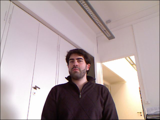

In [39]:
im.to_thumb(160)

In [40]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
def get_ctr(f):
    ctr = np.genfromtxt(img2pose(f), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1,c2])

In [41]:
get_ctr(img_files[0])

tensor([324.0023, 251.5637])

In [42]:
biwi = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=get_image_files,
    get_y=get_ctr,
    splitter=FuncSplitter(lambda o: o.parent.name=='13'),
    batch_tfms=[*aug_transforms(size=(240,320)), 
                Normalize.from_stats(*imagenet_stats)]
)

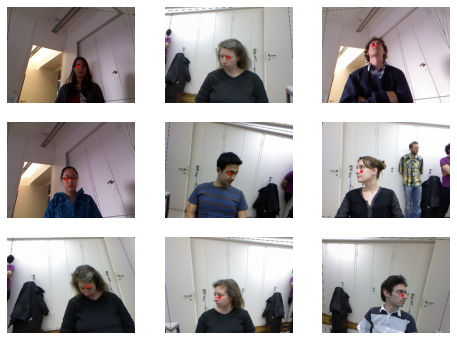

In [43]:
dls = biwi.dataloaders(path)
dls.show_batch(max_n=9, figsize=(8,6))

In [44]:
xb,yb = dls.one_batch()
xb.shape,yb.shape

(torch.Size([64, 3, 240, 320]), torch.Size([64, 1, 2]))

In [45]:
yb[0]

tensor([[-0.0794, -0.0545]], device='cuda:0')

### Training a Model

In [46]:
learn = cnn_learner(dls, resnet18, y_range=(-1,1))

In [47]:
def sigmoid_range(x, lo, hi): return torch.sigmoid(x) * (hi-lo) + lo

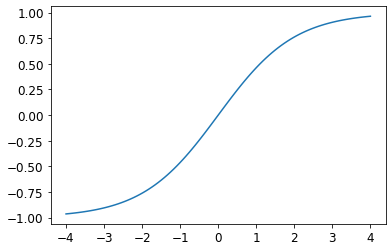

In [48]:
plot_function(partial(sigmoid_range,lo=-1,hi=1), min=-4, max=4)

In [49]:
dls.loss_func

FlattenedLoss of MSELoss()

(0.00831763744354248, 2.5118865210060903e-07)

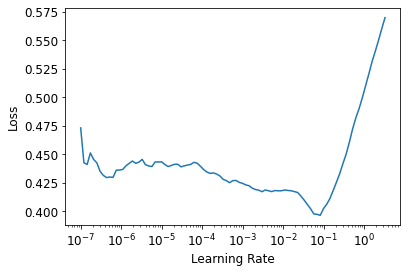

In [50]:
learn.lr_find()

In [51]:
lr = 1e-2
learn.fine_tune(3, lr)

epoch,train_loss,valid_loss,time
0,0.048200,0.003980,02:34


epoch,train_loss,valid_loss,time
0,0.008366,0.001521,03:25
1,0.002997,0.000175,03:24
2,0.001480,0.000334,03:24


In [52]:
math.sqrt(0.0001)

0.01

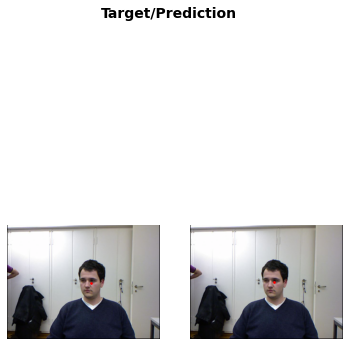

In [54]:
learn.show_results(ds_idx=1, max_n=3, figsize=(6,8))